In [1]:
# ============================================================================
# MODULE 1

# ============================================================================

"""
CELL 1: Install Compatible Libraries and Import
Run this first in your Kaggle notebook
"""

# First install specific compatible versions
!pip install scikit-image==0.19.3 opencv-python numpy==1.23.5 -q

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage import io, color, exposure, filters, restoration
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
import os
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
print("✓ Libraries imported successfully!")
print(f"NumPy version: {np.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 55.7 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 65.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 28.2 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
mkl-umath 0.1.1 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-random 1.2.4 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
mkl-fft 1.3.8 requires numpy<1.27.0,>=1.26.4, but you have numpy 1.23.5 which is incompatible.
datasets 4.4.1 requires pyarrow>=

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# Root dataset path
DATASET_PATH = '/kaggle/input/dataset-tomato-split/train'

# List all subfolders (classes)
subfolders = [f for f in os.listdir(DATASET_PATH) 
              if os.path.isdir(os.path.join(DATASET_PATH, f))]
print("Found subfolders (classes):", subfolders)

# Folder dropdown
folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Select class:',
    layout=widgets.Layout(width='90%')
)
display(folder_dropdown)

# Image dropdown (empty first)
image_dropdown = widgets.Dropdown(
    options=[],
    description='Select image:',
    layout=widgets.Layout(width='90%')
)
display(image_dropdown)

# Output area
out = widgets.Output()
display(out)

# Update images when folder changes
def update_images(change):
    folder_path = os.path.join(DATASET_PATH, folder_dropdown.value)
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    image_dropdown.options = images
    if images:
        image_dropdown.value = images[0]  # auto-select first image

folder_dropdown.observe(update_images, names='value')

# Display selected image
def display_image(change):
    with out:
        clear_output(wait=True)
        img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
        
        img = cv2.imread(img_path)
        if img is None:
            print("Failed to load image!")
            return
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image: {image_dropdown.value}")
        plt.show()

        print(f"Image shape: {img.shape}")
        print(f"Loaded from: {img_path}")

image_dropdown.observe(display_image, names='value')

# Initialize first folder at start
update_images(None)


In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import cv2
import matplotlib.pyplot as plt
import os

# ---------- Helper: Show multiple images ----------
def show_images(images, titles, rows=1, figsize=(15,5)):
    cols = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(titles[i])
    plt.show()

# ---------- DATASET ROOT ----------
DATASET_PATH = '/kaggle/input/tomato/train'

# List subfolders
subfolders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
print("Found subfolders (classes):", subfolders)

# ---------- Dropdown widgets ----------
folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Select folder:',
    layout=widgets.Layout(width='90%')
)
image_dropdown = widgets.Dropdown(
    options=[],
    description='Select image:',
    layout=widgets.Layout(width='90%')
)

out = widgets.Output()

display(folder_dropdown)
display(image_dropdown)
display(out)

# ---------- Update images when folder changes ----------
def update_images(change):
    folder_path = os.path.join(DATASET_PATH, folder_dropdown.value)
    images = [f for f in os.listdir(folder_path)
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    image_dropdown.options = images
    if images:
        image_dropdown.value = images[0]

folder_dropdown.observe(update_images, names='value')

# ---------- Display image + apply geometric transforms ----------
def display_and_transform(change):
    with out:
        clear_output(wait=True)

        img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
        if not os.path.isfile(img_path):
            print("File not found:", img_path)
            return

        # Read image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        center = (w // 2, h // 2)

        # -------------------------------
        # ORIGINAL IMAGE
        # -------------------------------
        print(f"Selected Image: {image_dropdown.value}")
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Original")
        plt.show()

        # ====================================================================
        # 1. ROTATION ONLY
        # ====================================================================
        angles = [30, 60, 120]
        rotated = []

        for a in angles:
            M = cv2.getRotationMatrix2D(center, a, 1.0)
            rotated.append(cv2.warpAffine(img, M, (w, h)))

        show_images(rotated, [f"Rotate {a}°" for a in angles])

        # ====================================================================
        # 2. TRANSLATION ONLY
        # ====================================================================
        translations = [(30, 0), (0, 30), (30, 30)]
        translated = []

        for tx, ty in translations:
            M = np.float32([[1, 0, tx], [0, 1, ty]])
            translated.append(cv2.warpAffine(img, M, (w, h)))

        show_images(translated, [f"Translate ({tx},{ty})" for tx, ty in translations])

        # ====================================================================
        # 3. BRIGHTNESS
        # ====================================================================
        brighter = cv2.convertScaleAbs(img, alpha=1.0, beta=40)   # +40 brightness
        darker = cv2.convertScaleAbs(img, alpha=1.0, beta=-40)    # -40 brightness

        show_images([darker, img, brighter],
                    ["Brightness -40", "Original", "Brightness +40"])

        # ====================================================================
        # 4. CONTRAST
        # ====================================================================
        low_contrast = cv2.convertScaleAbs(img, alpha=0.6, beta=0)
        high_contrast = cv2.convertScaleAbs(img, alpha=1.5, beta=0)

        show_images([low_contrast, img, high_contrast],
                    ["Low Contrast", "Original", "High Contrast"])

        print("✓ Rotation, Translation, Brightness, Contrast applied.")

# trigger when image is selected
image_dropdown.observe(display_and_transform, names='value')

# initialize
update_images(None)


Found subfolders (classes): ['Late_blight', 'Tomato_Yellow_Leaf_Curl_Virus', 'Septoria_leaf_spot', 'Early_blight', 'Spider_mites Two-spotted_spider_mite', 'powdery_mildew', 'healthy', 'Bacterial_spot', 'Target_Spot', 'Tomato_mosaic_virus', 'Leaf_Mold']


Dropdown(description='Select folder:', layout=Layout(width='90%'), options=('Late_blight', 'Tomato_Yellow_Leaf…

Dropdown(description='Select image:', layout=Layout(width='90%'), options=(), value=None)

Output()

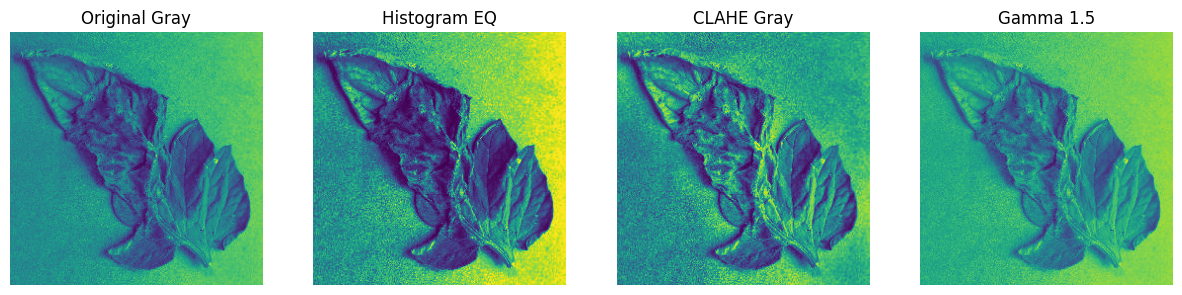

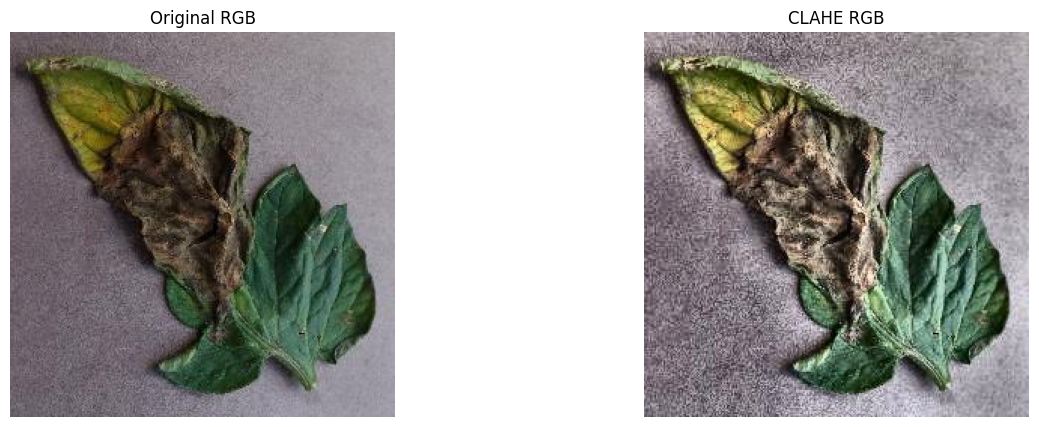

✓ Intensity transformations completed!
  ✔ CLAHE gives the best balanced contrast enhancement


In [9]:
"""
CELL 5: Intensity Transformations (UPDATED to use selected image)
"""

# Load image selected by the user
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

if not os.path.isfile(img_path):
    print(f"❌ File not found: {img_path}")
else:
    # Read + convert to RGB
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Histogram Equalization
    hist_eq = cv2.equalizeHist(gray)

    # CLAHE (better than regular histogram eq)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    clahe_result = clahe.apply(gray)

    # Gamma Correction
    gamma = 1.5
    inv_gamma = 1.0 / gamma
    table = np.array([((i/255.0)**inv_gamma)*255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(gray, table)

    # Display grayscale-based intensity transformations
    results = [gray, hist_eq, clahe_result, gamma_corrected]
    titles = ['Original Gray', 'Histogram EQ', 'CLAHE Gray', f'Gamma {gamma}']

    show_images(results, titles, rows=1)

    # Apply CLAHE to RGB image (L-channel only)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    img_lab[:, :, 0] = clahe.apply(img_lab[:, :, 0])
    img_clahe_rgb = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)

    # Display original vs CLAHE-enhanced RGB
    show_images([img, img_clahe_rgb], ['Original RGB', 'CLAHE RGB'], rows=1)

    print("✓ Intensity transformations completed!")
    print("  ✔ CLAHE gives the best balanced contrast enhancement")


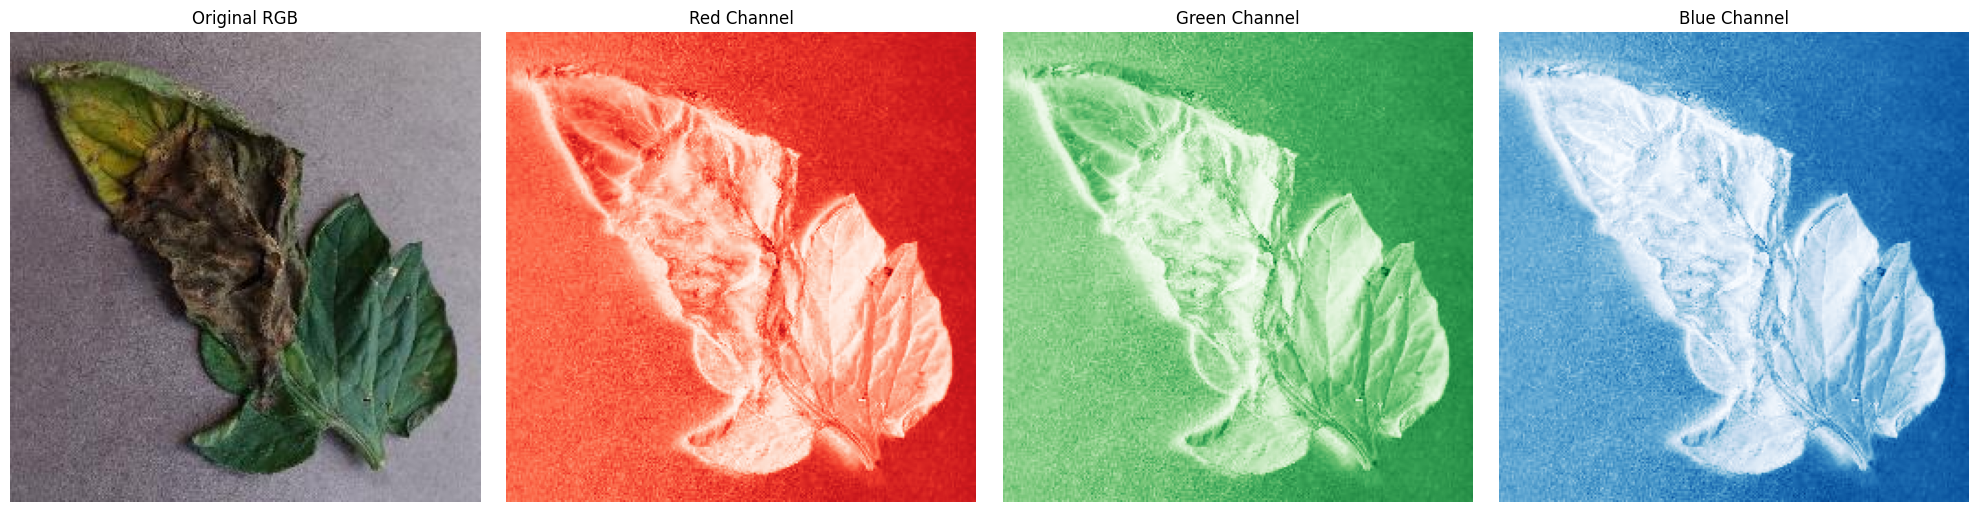

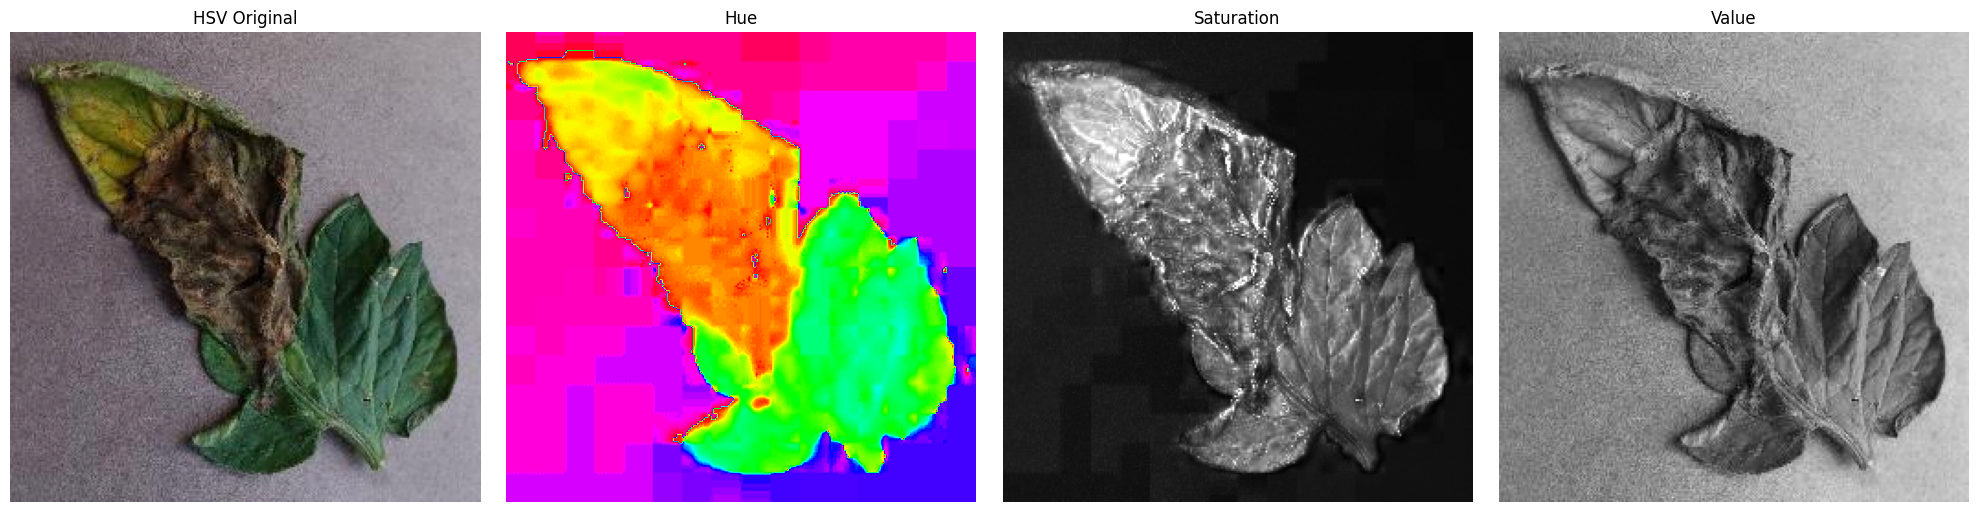

✓ Color space analysis completed!
  Key insight: HSV HUE channel often reveals disease patterns best.


In [10]:
"""
CELL 6: Color Space Analysis
"""

# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

if not os.path.isfile(img_path):
    print(f"❌ File not found: {img_path}")
else:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to different color spaces
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)

    # --- RGB Channels ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(img)
    axes[0].set_title('Original RGB')
    axes[1].imshow(img[:,:,0], cmap='Reds')
    axes[1].set_title('Red Channel')
    axes[2].imshow(img[:,:,1], cmap='Greens')
    axes[2].set_title('Green Channel')
    axes[3].imshow(img[:,:,2], cmap='Blues')
    axes[3].set_title('Blue Channel')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    # --- HSV Channels ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].imshow(cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB))
    axes[0].set_title('HSV Original')
    axes[1].imshow(img_hsv[:,:,0], cmap='hsv')
    axes[1].set_title('Hue')
    axes[2].imshow(img_hsv[:,:,1], cmap='gray')
    axes[2].set_title('Saturation')
    axes[3].imshow(img_hsv[:,:,2], cmap='gray')
    axes[3].set_title('Value')

    for ax in axes:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

    print("✓ Color space analysis completed!")
    print("  Key insight: HSV HUE channel often reveals disease patterns best.")


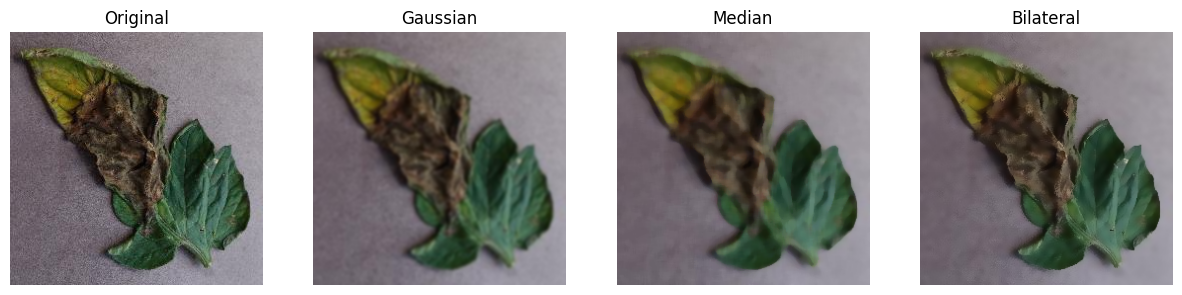

✓ Filtering completed!
  Bilateral filter preserves edges best while smoothing


In [11]:
"""
CELL 7: Filtering Techniques
"""
# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

# Different filters
gaussian = cv2.GaussianBlur(img, (7, 7), 0)
median = cv2.medianBlur(img, 7)
bilateral = cv2.bilateralFilter(img, 9, 75, 75)

# Display
filters = [img, gaussian, median, bilateral]
titles = ['Original', 'Gaussian', 'Median', 'Bilateral']
show_images(filters, titles, rows=1)

print("✓ Filtering completed!")
print("  Bilateral filter preserves edges best while smoothing")

# ============================================================================


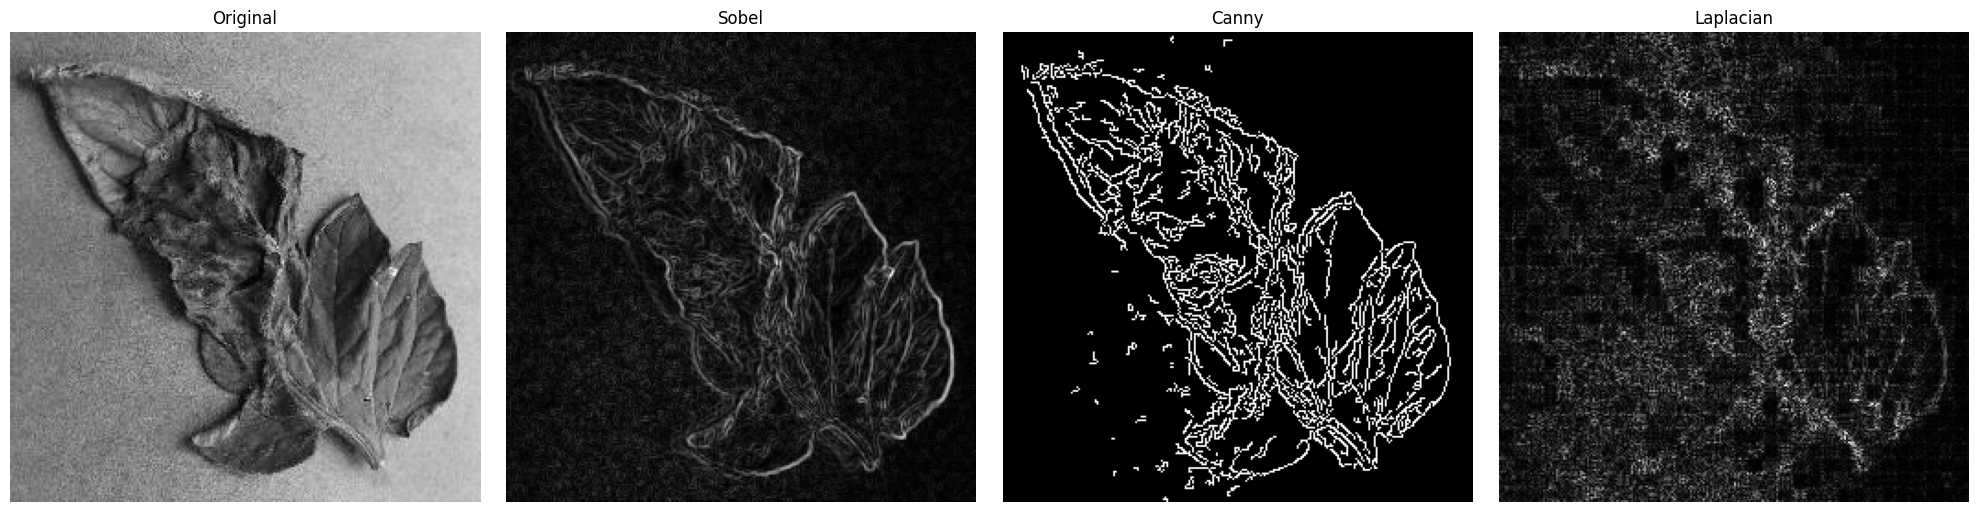

✓ Edge detection completed!
  Canny provides cleanest edge detection


In [12]:
"""
CELL 8: Edge Detection
"""
# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
sobel = np.sqrt(sobelx**2 + sobely**2)
sobel = np.uint8(sobel / sobel.max() * 255)

# Canny
canny = cv2.Canny(gray, 100, 200)

# Laplacian
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
laplacian = np.uint8(np.absolute(laplacian))

# Display
edges = [gray, sobel, canny, laplacian]
titles = ['Original', 'Sobel', 'Canny', 'Laplacian']

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for ax, edge, title in zip(axes, edges, titles):
    ax.imshow(edge, cmap='gray')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout()
plt.show()

print("✓ Edge detection completed!")
print("  Canny provides cleanest edge detection")

# ============================================================================


In [14]:
"""
CELL 9: Noise Addition and Restoration
"""

# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

# Add Gaussian noise
img_float = img.astype(float) / 255.0
noisy = random_noise(img_float, mode='gaussian', var=0.01)
noisy = (noisy * 255).astype(np.uint8)

# Restoration methods
restored_gaussian = cv2.GaussianBlur(noisy, (5, 5), 0)
restored_median = cv2.medianBlur(noisy, 5)
restored_bilateral = cv2.bilateralFilter(noisy, 9, 75, 75)
restored_nlm = cv2.fastNlMeansDenoisingColored(noisy, None, 10, 10, 7, 21)

# Display
results = [img, noisy, restored_gaussian, restored_median, 
          restored_bilateral, restored_nlm]
titles = ['Original', 'Noisy', 'Gaussian', 'Median', 'Bilateral', 'NL Means']
show_images(results, titles, rows=2)

# Calculate metrics
print("\nRestoration Quality (PSNR):")
for name, restored in [('Gaussian', restored_gaussian), 
                       ('Median', restored_median),
                       ('Bilateral', restored_bilateral), 
                       ('NL Means', restored_nlm)]:
    psnr_val = psnr(img, restored)
    ssim_val = ssim(img, restored, channel_axis=2)
    print(f"  {name:12s}: PSNR={psnr_val:.2f} dB, SSIM={ssim_val:.4f}")

print("\n✓ Noise restoration completed!")
print("  Best performer: Non-Local Means Denoising")

# ============================================================================


NameError: name 'random_noise' is not defined

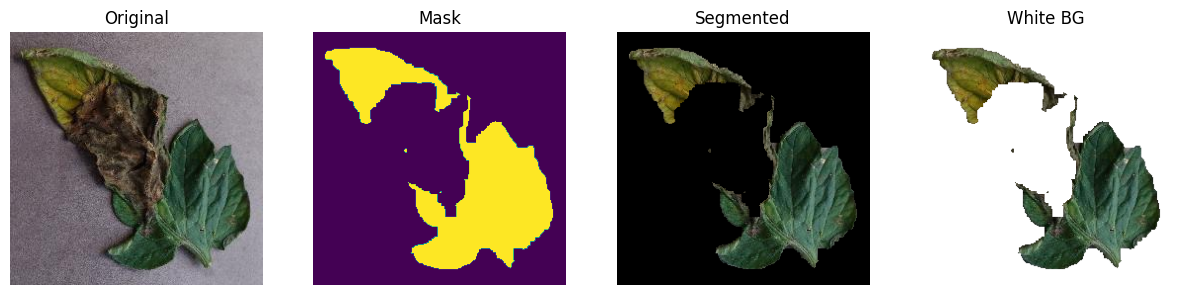

✓ Leaf segmentation completed!
  Tip: Adjust HSV ranges if segmentation is poor


In [15]:
"""
CELL 10: Leaf Segmentation
"""
# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

# Convert to HSV for color-based segmentation
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Define green color range (adjust for your dataset)
lower_green = np.array([25, 40, 40])
upper_green = np.array([85, 255, 255])

# Create mask
mask = cv2.inRange(hsv, lower_green, upper_green)

# Morphological operations
kernel = np.ones((5,5), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

# Apply mask
segmented = cv2.bitwise_and(img, img, mask=mask_clean)

# White background version
white_bg = img.copy()
white_bg[mask_clean == 0] = [255, 255, 255]

# Display
show_images([img, mask_clean, segmented, white_bg],
           ['Original', 'Mask', 'Segmented', 'White BG'], rows=1)

print("✓ Leaf segmentation completed!")
print("  Tip: Adjust HSV ranges if segmentation is poor")

# ============================================================================


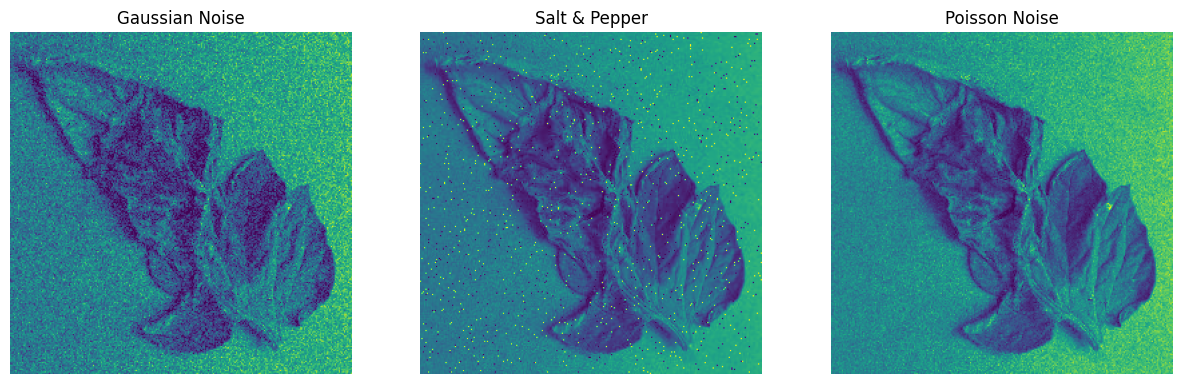

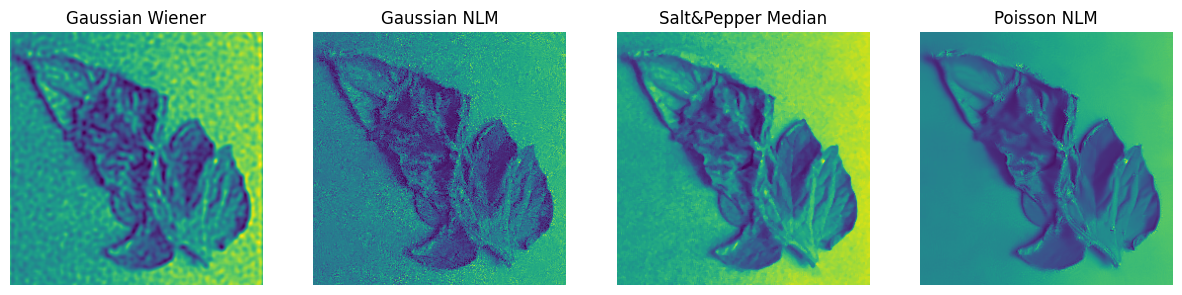

In [16]:
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
import cv2
import numpy as np
from skimage.restoration import wiener

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# ----------------------------
# 1. Add Gaussian Noise
# ----------------------------
mean = 0
var = 0.01
sigma = np.sqrt(var)
gaussian_noise = np.random.normal(mean, sigma, gray.shape)
gaussian_noisy = gray.astype(np.float32)/255 + gaussian_noise
gaussian_noisy = np.clip(gaussian_noisy, 0, 1)

# ----------------------------
# 2. Add Salt & Pepper Noise
# ----------------------------
sp_noisy = gray.copy().astype(np.float32)/255
prob = 0.02
rand = np.random.rand(*gray.shape)
sp_noisy[rand < prob/2] = 0
sp_noisy[rand > 1 - prob/2] = 1

# ----------------------------
# 3. Add Poisson Noise
# ----------------------------
vals = 2 ** np.ceil(np.log2(len(np.unique(gray))))
poisson_noisy = np.random.poisson(gray / 255.0 * vals)
poisson_noisy = poisson_noisy / np.max(poisson_noisy)
poisson_noisy = np.clip(poisson_noisy, 0, 1)

# ----------------------------
# Show Noisy Images
# ----------------------------
show_images(
    [gaussian_noisy*255, sp_noisy*255, poisson_noisy*255],
    ["Gaussian Noise", "Salt & Pepper", "Poisson Noise"],
    rows=1
)

# =========================
# RESTORATION
# =========================

# ---------- Gaussian Noise ----------
# Wiener Filter
kernel = np.ones((5,5)) / 25
wiener_restored = wiener(gaussian_noisy, kernel, balance=0.5)
wiener_restored = np.clip(wiener_restored*255, 0, 255).astype(np.uint8)

# Non-Local Means (OpenCV works with uint8)
nlm_restored = cv2.fastNlMeansDenoising((gaussian_noisy*255).astype(np.uint8),
                                        None, h=15, templateWindowSize=7, searchWindowSize=21)

# ---------- Salt & Pepper Noise ----------
median_restored = cv2.medianBlur((sp_noisy*255).astype(np.uint8), ksize=3)

# ---------- Poisson Noise ----------
poisson_nlm = cv2.fastNlMeansDenoising((poisson_noisy*255).astype(np.uint8),
                                       None, h=15, templateWindowSize=7, searchWindowSize=21)

# ----------------------------
# Show Restored Images
# ----------------------------
show_images(
    [wiener_restored, nlm_restored, median_restored, poisson_nlm],
    ["Gaussian Wiener", "Gaussian NLM", "Salt&Pepper Median", "Poisson NLM"],
    rows=1
)


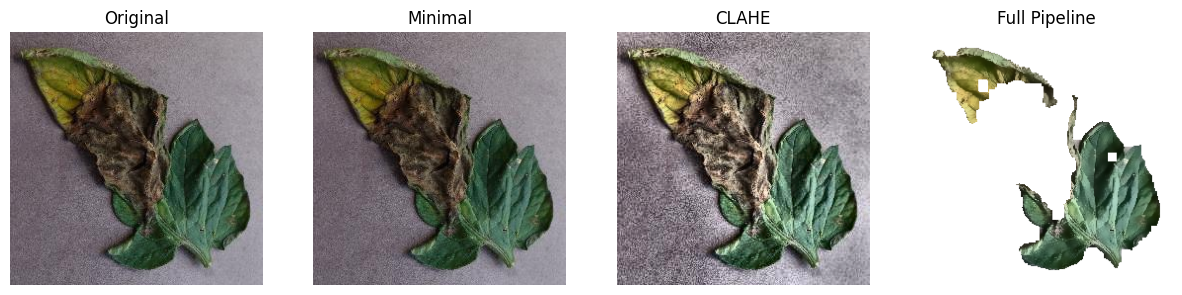

✓ Preprocessing pipeline comparison completed!

Recommendation: Use 'full' pipeline for best results


In [17]:
"""
CELL 11: Complete Preprocessing Pipeline
"""
# Ensure the selected image is loaded
img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)

def preprocess_image(img, pipeline='full'):
    """
    Apply complete preprocessing pipeline
    
    Pipelines:
    - 'minimal': Just resize
    - 'clahe': Resize + CLAHE
    - 'full': Resize + Bilateral + CLAHE + Segmentation
    """
    target_size = (256, 256)
    
    # Resize
    processed = cv2.resize(img, target_size)
    
    if pipeline in ['clahe', 'full']:
        # Apply CLAHE
        img_lab = cv2.cvtColor(processed, cv2.COLOR_RGB2LAB)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_lab[:,:,0] = clahe.apply(img_lab[:,:,0])
        processed = cv2.cvtColor(img_lab, cv2.COLOR_LAB2RGB)
    
    if pipeline == 'full':
        # Apply bilateral filter
        processed = cv2.bilateralFilter(processed, 9, 75, 75)
        
        # Segment leaf
        hsv = cv2.cvtColor(processed, cv2.COLOR_RGB2HSV)
        lower = np.array([25, 40, 40])
        upper = np.array([85, 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        processed = cv2.bitwise_and(processed, processed, mask=mask)
        processed[mask == 0] = [255, 255, 255]
    
    return processed

# Test different pipelines
minimal = preprocess_image(img, 'minimal')
clahe_only = preprocess_image(img, 'clahe')
full = preprocess_image(img, 'full')

show_images([img, minimal, clahe_only, full],
           ['Original', 'Minimal', 'CLAHE', 'Full Pipeline'], rows=1)

print("✓ Preprocessing pipeline comparison completed!")
print("\nRecommendation: Use 'full' pipeline for best results")

# ============================================================================


In [ ]:
"""
CELL 12: Batch Process Multiple Images (Select Subfolder)
"""

import os
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output

# Output folder
output_dir = 'preprocessed'
os.makedirs(output_dir, exist_ok=True)

# Get subfolders inside dataset
subfolders = [os.path.join(DATASET_PATH, d) for d in os.listdir(DATASET_PATH) 
              if os.path.isdir(os.path.join(DATASET_PATH, d))]

# Dropdown to select subfolder
folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Select folder:',
    layout=widgets.Layout(width='80%')
)
display(folder_dropdown)

# Output widget for messages
out = widgets.Output()
display(out)

# Updated process_and_save function
def process_and_save(image_path, output_dir='preprocessed'):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        processed = preprocess_image(img, 'full')  # keep RGB
        filename = os.path.basename(image_path)
        output_path = os.path.join(output_dir, filename)
        cv2.imwrite(output_path, cv2.cvtColor(processed, cv2.COLOR_RGB2BGR))
        return output_path
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# When subfolder is selected, process images
def process_folder(change):
    folder = folder_dropdown.value
    if not folder:
        return
    
    image_paths = [os.path.join(folder, f) for f in os.listdir(folder) 
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    with out:
        clear_output(wait=True)
        print(f"Found {len(image_paths)} images in folder: {folder}")
        print("Processing images...")
        processed_count = 0
        for img_path in image_paths:
            if process_and_save(img_path, output_dir):
                processed_count += 1
        print(f"\n✓ Processed {processed_count} images")
        print(f"Saved to: /kaggle/working/{output_dir}/")

# Attach function to dropdown
folder_dropdown.observe(process_folder, names='value')


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the unzipped dataset in /kaggle/working
dataset_dir = '/kaggle/working/preprocessed'  # Change if your folder name is different

# List files
images = [f for f in os.listdir(dataset_dir) if f.endswith('.jpg') or f.endswith('.png')]
print("Images found:", images[:5])  # Show first 5 image names

# Display first image
img_path = os.path.join(dataset_dir, images[1])
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()


> **Module 2**

In [26]:
"""
CELL 1: Install Additional Libraries
"""
!pip install scikit-image -q

print("✓ Libraries installed!")

# ============================================================================

"""
CELL 2: Import All Libraries
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support)
from sklearn.cluster import KMeans

np.random.seed(42)
plt.style.use('default')

print("✓ All libraries imported!")

# ============================================================================

✓ Libraries installed!
✓ All libraries imported!


In [18]:
# Paths
DATASET_PATH = '/kaggle/input/tomato/train'  # Corrected path
OUTPUT_PATH = '/kaggle/working/module2/'

# Create directories
os.makedirs(f'{OUTPUT_PATH}features/', exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}visualizations/', exist_ok=True)
os.makedirs(f'{OUTPUT_PATH}results/', exist_ok=True)

print(f"✓ Output directory: {OUTPUT_PATH}")


✓ Output directory: /kaggle/working/module2/


In [20]:
# ============================================================================
# COMPLETE FEATURE EXTRACTION SYSTEM WITH INTERACTIVE VISUALIZATION
# Combines: LBP, GLCM, HOG, Color Histograms, Color Moments
# ============================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION
# ============================================================================

DATASET_PATH = '/kaggle/input/tomato/train'

# Verify path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# ============================================================================
# STATE MANAGEMENT CLASS
# ============================================================================

class ImageFeatureState:
    """Centralized state management for image and extracted features"""
    def __init__(self):
        self.current_image = None
        self.current_path = None
        self.features = {}
        
    def load_image(self, path):
        """Load image once and cache it"""
        if path == self.current_path and self.current_image is not None:
            return self.current_image
            
        img = cv2.imread(path)
        if img is None:
            raise ValueError(f"Failed to load image: {path}")
        
        # Robust format handling
        if len(img.shape) == 2:  # Grayscale
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.shape[2] == 4:  # RGBA
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:  # BGR
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
        self.current_image = img
        self.current_path = path
        self.features = {}  # Reset features when new image loaded
        return img
    
    def get_grayscale(self):
        """Get grayscale version of current image"""
        if self.current_image is None:
            raise ValueError("No image loaded")
        
        if len(self.current_image.shape) == 2:
            return self.current_image
        return cv2.cvtColor(self.current_image, cv2.COLOR_RGB2GRAY)

# Initialize state
state = ImageFeatureState()

# ============================================================================
# FEATURE EXTRACTION FUNCTIONS
# ============================================================================

# -----------------------------------------------------------------------------
# 1. LBP (Local Binary Pattern) - Texture Analysis
# -----------------------------------------------------------------------------

def extract_lbp(image, radius=3, n_points=24, return_image=False):
    """
    Extract LBP texture features
    
    Args:
        image: RGB image (numpy array)
        radius: Radius of circular neighborhood
        n_points: Number of sampling points
        return_image: If True, return LBP image for visualization
        
    Returns:
        hist: Normalized histogram of LBP patterns
        lbp_image: (optional) LBP pattern image
    """
    try:
        # Convert to grayscale safely
        if len(image.shape) == 2:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Compute LBP
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Calculate histogram
        n_bins = n_points + 2
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        
        # Normalize
        hist = hist.astype('float')
        hist /= (hist.sum() + 1e-7)
        
        if return_image:
            return hist, lbp.astype(np.uint8)
        return hist
        
    except Exception as e:
        raise RuntimeError(f"LBP extraction failed: {str(e)}")

# -----------------------------------------------------------------------------
# 2. GLCM (Gray Level Co-occurrence Matrix) - Spatial Texture
# -----------------------------------------------------------------------------

def extract_glcm(image, distances=[1, 2, 3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], 
                return_image=False):
    """
    Extract GLCM texture features
    
    Args:
        image: RGB image
        distances: List of pixel distances
        angles: List of angles in radians
        return_image: If True, return grayscale image used
        
    Returns:
        features: Array of GLCM properties (contrast, dissimilarity, etc.)
        gray: (optional) Grayscale image used for GLCM
    """
    try:
        # Convert to grayscale
        if len(image.shape) == 2:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Reduce gray levels for computational efficiency
        gray_reduced = (gray / 32).astype(np.uint8)
        
        # Compute GLCM
        glcm = graycomatrix(gray_reduced, distances=distances, angles=angles,
                           levels=8, symmetric=True, normed=True)
        
        # Extract properties
        features = []
        properties = ['contrast', 'dissimilarity', 'homogeneity', 
                     'energy', 'correlation', 'ASM']
        
        for prop in properties:
            prop_values = graycoprops(glcm, prop).flatten()
            features.extend(prop_values)
        
        features = np.array(features)
        
        if return_image:
            return features, gray
        return features
        
    except Exception as e:
        raise RuntimeError(f"GLCM extraction failed: {str(e)}")

# -----------------------------------------------------------------------------
# 3. HOG (Histogram of Oriented Gradients) - Shape/Edge Features
# -----------------------------------------------------------------------------

def extract_hog(image, orientations=9, pixels_per_cell=(8, 8), 
               cells_per_block=(2, 2), return_image=False):
    """
    Extract HOG shape features
    
    Args:
        image: RGB image
        orientations: Number of orientation bins
        pixels_per_cell: Size of a cell
        cells_per_block: Number of cells in each block
        return_image: If True, return HOG visualization
        
    Returns:
        features: HOG feature vector
        hog_image: (optional) HOG visualization
    """
    try:
        # Convert to grayscale
        if len(image.shape) == 2:
            gray = image
        else:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        
        # Extract HOG features
        if return_image:
            features, hog_image = hog(
                gray,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=True,
                feature_vector=True
            )
            return features, hog_image
        else:
            features = hog(
                gray,
                orientations=orientations,
                pixels_per_cell=pixels_per_cell,
                cells_per_block=cells_per_block,
                block_norm='L2-Hys',
                visualize=False,
                feature_vector=True
            )
            return features
            
    except Exception as e:
        raise RuntimeError(f"HOG extraction failed: {str(e)}")

# -----------------------------------------------------------------------------
# 4. Color Histogram - Color Distribution
# -----------------------------------------------------------------------------

def extract_color_histogram(image, bins=32, color_space='HSV', return_image=False):
    """
    Extract color histogram features
    
    Args:
        image: RGB image
        bins: Number of histogram bins per channel
        color_space: 'RGB', 'HSV', or 'LAB'
        return_image: If True, return converted image
        
    Returns:
        histogram: Concatenated histograms for all channels
        converted: (optional) Image in target color space
    """
    try:
        # Convert color space
        if color_space == 'HSV':
            converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LAB':
            converted = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        elif color_space == 'RGB':
            converted = image.copy()
        else:
            raise ValueError(f"Unknown color space: {color_space}")
        
        # Calculate histogram for each channel
        histograms = []
        for i in range(3):
            hist, _ = np.histogram(converted[:,:,i], bins=bins, 
                                 range=(0, 256), density=True)
            histograms.extend(hist)
        
        hist_array = np.array(histograms)
        
        if return_image:
            return hist_array, converted
        return hist_array
        
    except Exception as e:
        raise RuntimeError(f"Color histogram extraction failed: {str(e)}")

# -----------------------------------------------------------------------------
# 5. Color Moments - Statistical Color Features
# -----------------------------------------------------------------------------

def extract_color_moments(image, color_space='HSV', return_image=False):
    """
    Extract color statistical moments (mean, std, skewness, kurtosis)
    
    Args:
        image: RGB image
        color_space: 'RGB', 'HSV', or 'LAB'
        return_image: If True, return converted image
        
    Returns:
        moments: Array of statistical moments for each channel
        converted: (optional) Image in target color space
    """
    try:
        # Convert color space
        if color_space == 'HSV':
            converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LAB':
            converted = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        elif color_space == 'RGB':
            converted = image.copy()
        else:
            raise ValueError(f"Unknown color space: {color_space}")
        
        # Calculate moments for each channel
        moments = []
        for i in range(3):
            channel = converted[:,:,i].flatten()
            moments.extend([
                np.mean(channel),           # Mean
                np.std(channel),            # Standard deviation
                skew(channel),              # Skewness
                kurtosis(channel)           # Kurtosis
            ])
        
        moments_array = np.array(moments)
        
        if return_image:
            return moments_array, converted
        return moments_array
        
    except Exception as e:
        raise RuntimeError(f"Color moments extraction failed: {str(e)}")

# -----------------------------------------------------------------------------
# 6. Combined Feature Extraction
# -----------------------------------------------------------------------------

def extract_all_features(image, return_visualizations=False):
    """
    Extract all features from image in one call
    
    Args:
        image: RGB image
        return_visualizations: If True, return images for visualization
        
    Returns:
        features: Combined feature vector
        visualizations: (optional) Dictionary of visualization images
    """
    try:
        visualizations = {}
        
        # Extract all features
        lbp_hist, lbp_img = extract_lbp(image, return_image=True)
        glcm_features, glcm_img = extract_glcm(image, return_image=True)
        hog_features, hog_img = extract_hog(image, return_image=True)
        hist_rgb, rgb_img = extract_color_histogram(image, color_space='RGB', return_image=True)
        hist_hsv, hsv_img = extract_color_histogram(image, color_space='HSV', return_image=True)
        moments_rgb = extract_color_moments(image, color_space='RGB')
        moments_hsv = extract_color_moments(image, color_space='HSV')
        
        # Combine all features
        combined_features = np.concatenate([
            lbp_hist,           # 26 features
            glcm_features,      # 72 features
            hog_features,       # ~8000 features (depends on image size)
            hist_rgb,           # 96 features (32 bins × 3 channels)
            hist_hsv,           # 96 features
            moments_rgb,        # 12 features (4 moments × 3 channels)
            moments_hsv         # 12 features
        ])
        
        if return_visualizations:
            visualizations = {
                'lbp': lbp_img,
                'glcm': glcm_img,
                'hog': hog_img,
                'rgb': rgb_img,
                'hsv': hsv_img
            }
            return combined_features, visualizations
        
        return combined_features
        
    except Exception as e:
        raise RuntimeError(f"Combined feature extraction failed: {str(e)}")

# ============================================================================
# VISUALIZATION FUNCTIONS
# ============================================================================

def visualize_all_features(image):
    """
    Create comprehensive visualization of all extracted features
    
    Args:
        image: RGB image
    """
    try:
        # Extract features with visualizations
        features, vis_images = extract_all_features(image, return_visualizations=True)
        
        # Also get individual feature vectors for detailed display
        lbp_hist, _ = extract_lbp(image, return_image=True)
        glcm_features, _ = extract_glcm(image, return_image=True)
        hog_features, _ = extract_hog(image, return_image=True)
        hist_hsv, _ = extract_color_histogram(image, color_space='HSV', return_image=True)
        moments_hsv = extract_color_moments(image, color_space='HSV')
        
        # Create comprehensive visualization
        fig = plt.figure(figsize=(20, 12))
        
        # Row 1: Original and Feature Images
        plt.subplot(3, 5, 1)
        plt.imshow(image)
        plt.title('Original Image', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 5, 2)
        plt.imshow(vis_images['lbp'], cmap='gray')
        plt.title('LBP Pattern', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 5, 3)
        plt.imshow(vis_images['glcm'], cmap='gray')
        plt.title('GLCM (Grayscale)', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 5, 4)
        plt.imshow(vis_images['hog'], cmap='gray')
        plt.title('HOG Visualization', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        plt.subplot(3, 5, 5)
        plt.imshow(vis_images['hsv'])
        plt.title('HSV Color Space', fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Row 2: Feature Distributions
        plt.subplot(3, 5, 6)
        plt.bar(range(len(lbp_hist)), lbp_hist, color='steelblue')
        plt.title(f'LBP Histogram ({len(lbp_hist)} bins)', fontsize=11)
        plt.xlabel('Pattern')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 5, 7)
        plt.bar(range(len(glcm_features)), glcm_features, color='forestgreen')
        plt.title(f'GLCM Features ({len(glcm_features)})', fontsize=11)
        plt.xlabel('Feature Index')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 5, 8)
        plt.plot(hog_features[:200], color='darkred')
        plt.title(f'HOG (first 200 of {len(hog_features)})', fontsize=11)
        plt.xlabel('Feature Index')
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3)
        
        # Row 2, col 4: HSV Histogram
        plt.subplot(3, 5, 9)
        bins_per_channel = len(hist_hsv) // 3
        x = np.arange(bins_per_channel)
        plt.plot(x, hist_hsv[:bins_per_channel], label='Hue', color='red')
        plt.plot(x, hist_hsv[bins_per_channel:2*bins_per_channel], label='Sat', color='green')
        plt.plot(x, hist_hsv[2*bins_per_channel:], label='Val', color='blue')
        plt.title('HSV Histogram', fontsize=11)
        plt.xlabel('Bin')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Row 2, col 5: Color Moments
        plt.subplot(3, 5, 10)
        moment_labels = ['H-μ', 'H-σ', 'H-Skew', 'H-Kurt',
                        'S-μ', 'S-σ', 'S-Skew', 'S-Kurt',
                        'V-μ', 'V-σ', 'V-Skew', 'V-Kurt']
        colors_moments = ['red']*4 + ['green']*4 + ['blue']*4
        plt.bar(range(len(moments_hsv)), moments_hsv, color=colors_moments, alpha=0.7)
        plt.title('HSV Color Moments', fontsize=11)
        plt.xticks(range(len(moments_hsv)), moment_labels, rotation=45, ha='right', fontsize=8)
        plt.ylabel('Value')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Row 3: Feature Summary Statistics
        plt.subplot(3, 5, 11)
        feature_breakdown = {
            'LBP': len(lbp_hist),
            'GLCM': len(glcm_features),
            'HOG': len(hog_features),
            'Hist-RGB': len(hist_hsv),  # Same size as HSV
            'Hist-HSV': len(hist_hsv),
            'Mom-RGB': 12,
            'Mom-HSV': 12
        }
        plt.bar(feature_breakdown.keys(), feature_breakdown.values(), color='orchid')
        plt.title('Feature Vector Sizes', fontsize=11, fontweight='bold')
        plt.ylabel('Number of Features')
        plt.xticks(rotation=45, ha='right')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Row 3: Summary Text
        plt.subplot(3, 5, 12)
        plt.axis('off')
        summary_text = f"""
FEATURE EXTRACTION SUMMARY

Total Features: {len(features)}

Breakdown:
- LBP (texture): {len(lbp_hist)}
- GLCM (texture): {len(glcm_features)}
- HOG (shape): {len(hog_features)}
- RGB Histogram: {len(hist_hsv)}
- HSV Histogram: {len(hist_hsv)}
- RGB Moments: 12
- HSV Moments: 12

Image Shape: {image.shape}
        """
        plt.text(0.1, 0.5, summary_text, fontsize=10, verticalalignment='center',
                family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed information
        print("="*70)
        print("FEATURE EXTRACTION COMPLETE")
        print("="*70)
        print(f"\nTotal feature vector length: {len(features)}")
        print(f"\nFeature breakdown:")
        for name, count in feature_breakdown.items():
            print(f"  {name:12s}: {count:6d} features")
        print(f"\nFeature vector statistics:")
        print(f"  Min:    {features.min():.6f}")
        print(f"  Max:    {features.max():.6f}")
        print(f"  Mean:   {features.mean():.6f}")
        print(f"  Std:    {features.std():.6f}")
        
        return features
        
    except Exception as e:
        print(f"❌ Visualization failed: {str(e)}")
        raise

# ============================================================================
# INTERACTIVE WIDGET SETUP
# ============================================================================

# List subfolders (classes)
subfolders = [f for f in os.listdir(DATASET_PATH) 
              if os.path.isdir(os.path.join(DATASET_PATH, f))]

if not subfolders:
    raise ValueError("No subfolders found in dataset path!")

print(f"Found {len(subfolders)} classes:")
for i, f in enumerate(subfolders, 1):
    print(f"  {i}. {f}")

# Create widgets
folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Class:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '100px'}
)

image_dropdown = widgets.Dropdown(
    options=[],
    description='Image:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '100px'}
)

# Output widget
out_features = widgets.Output()

# Display widgets
display(widgets.HTML("<h2>🔬 Interactive Feature Extraction System</h2>"))
display(folder_dropdown)
display(image_dropdown)
display(out_features)

# ============================================================================
# WIDGET EVENT HANDLERS
# ============================================================================

def update_images(change):
    """Update image dropdown when folder changes"""
    folder_path = os.path.join(DATASET_PATH, folder_dropdown.value)
    images = [f for f in os.listdir(folder_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not images:
        with out_features:
            clear_output()
            print(f"⚠️ No images found in folder: {folder_dropdown.value}")
        image_dropdown.options = []
        return
    
    image_dropdown.options = images
    if images:
        image_dropdown.value = images[0]  # Trigger update

def update_features(change):
    """Extract and visualize features for selected image"""
    if not image_dropdown.value:
        return
    
    img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
    
    with out_features:
        clear_output(wait=True)
        
        try:
            print("Loading image and extracting features...")
            print(f"Path: {img_path}\n")
            
            # Load image using state management
            img = state.load_image(img_path)
            
            # Visualize all features
            features = visualize_all_features(img)
            
            # Store in state
            state.features['combined'] = features
            
            print(f"\n✅ Feature extraction successful!")
            print(f"✅ Features stored in state.features['combined']")
            
        except Exception as e:
            print(f"❌ Error: {str(e)}")
            import traceback
            traceback.print_exc()

# Attach observers
folder_dropdown.observe(update_images, names='value')
image_dropdown.observe(update_features, names='value')

# Initialize
update_images(None)

print("\n" + "="*70)
print("✅ INTERACTIVE FEATURE EXTRACTION SYSTEM READY")
print("="*70)
print("Select a class and image from the dropdowns above to extract features.")

Found 11 classes:
  1. Late_blight
  2. Tomato_Yellow_Leaf_Curl_Virus
  3. Septoria_leaf_spot
  4. Early_blight
  5. Spider_mites Two-spotted_spider_mite
  6. powdery_mildew
  7. healthy
  8. Bacterial_spot
  9. Target_Spot
  10. Tomato_mosaic_virus
  11. Leaf_Mold


HTML(value='<h2>🔬 Interactive Feature Extraction System</h2>')

Dropdown(description='Class:', layout=Layout(width='90%'), options=('Late_blight', 'Tomato_Yellow_Leaf_Curl_Vi…

Dropdown(description='Image:', layout=Layout(width='90%'), options=(), style=DescriptionStyle(description_widt…

Output()


✅ INTERACTIVE FEATURE EXTRACTION SYSTEM READY
Select a class and image from the dropdowns above to extract features.


In [21]:
# ============================================================================
# SIMPLE CORNER DETECTION SYSTEM WITH INTERACTIVE IMAGE SELECTION
# Detect corners using Harris, Shi-Tomasi, and FAST
# ============================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

# ---------------- CONFIGURATION ----------------
DATASET_PATH = '/kaggle/input/tomato/train'  # Change if needed

if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset path not found: {DATASET_PATH}")

# ---------------- LIST CLASSES ----------------
subfolders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]
if not subfolders:
    raise ValueError("No subfolders found in dataset path!")

print(f"Found {len(subfolders)} classes:")
for i, f in enumerate(subfolders, 1):
    print(f"  {i}. {f}")

# ---------------- CREATE WIDGETS ----------------
folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Class:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '100px'}
)

image_dropdown = widgets.Dropdown(
    options=[],
    description='Image:',
    layout=widgets.Layout(width='90%'),
    style={'description_width': '100px'}
)

out_corner = widgets.Output()

display(widgets.HTML("<h2>🔹 Interactive Corner Detection</h2>"))
display(folder_dropdown)
display(image_dropdown)
display(out_corner)

# ---------------- UPDATE IMAGES ----------------
def update_images(change):
    """Update image dropdown when folder changes"""
    folder_path = os.path.join(DATASET_PATH, folder_dropdown.value)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    if not images:
        with out_corner:
            clear_output()
            print(f"⚠️ No images found in folder: {folder_dropdown.value}")
        image_dropdown.options = []
        return
    
    image_dropdown.options = images
    if images:
        image_dropdown.value = images[0]  # Trigger update

# ---------------- CORNER DETECTION ----------------
def corner_detection(change):
    """Detect corners for the selected image"""
    if not image_dropdown.value:
        return
    
    img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
    
    with out_corner:
        clear_output(wait=True)
        print(f"Image Path: {img_path}\n")
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("Error: Could not load image!")
            return
        
        try:
            # ---------------- Harris ----------------
            harris_response = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
            harris_response = cv2.dilate(harris_response, None)
            harris_corners = np.argwhere(harris_response > 0.01 * harris_response.max())
            img_harris = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
            for y, x in harris_corners:
                cv2.circle(img_harris, (x, y), 4, (0, 0, 255), -1)
            
            # ---------------- Shi-Tomasi ----------------
            shi_tomasi_corners = cv2.goodFeaturesToTrack(img, maxCorners=100, qualityLevel=0.01, minDistance=10)
            img_shi_tomasi = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
            if shi_tomasi_corners is not None:
                for corner in shi_tomasi_corners:
                    x, y = corner.ravel()
                    cv2.circle(img_shi_tomasi, (int(x), int(y)), 5, (0, 255, 0), 1)
            
            # ---------------- FAST ----------------
            fast = cv2.FastFeatureDetector_create(threshold=20)
            fast_keypoints = fast.detect(img, None)
            img_fast = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
            for kp in fast_keypoints:
                x, y = int(kp.pt[0]), int(kp.pt[1])
                cv2.circle(img_fast, (x, y), 5, (255, 0, 0), -1)
            
            # ---------------- DISPLAY ----------------
            fig, axes = plt.subplots(2, 2, figsize=(14, 12))
            
            axes[0, 0].imshow(img, cmap='gray')
            axes[0, 0].set_title('Original Image')
            axes[0, 0].axis('off')
            
            axes[0, 1].imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
            axes[0, 1].set_title(f'Harris Corners: {len(harris_corners)}', color='red')
            axes[0, 1].axis('off')
            
            shi_count = len(shi_tomasi_corners) if shi_tomasi_corners is not None else 0
            axes[1, 0].imshow(cv2.cvtColor(img_shi_tomasi, cv2.COLOR_BGR2RGB))
            axes[1, 0].set_title(f'Shi-Tomasi Corners: {shi_count}', color='green')
            axes[1, 0].axis('off')
            
            axes[1, 1].imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
            axes[1, 1].set_title(f'FAST Corners: {len(fast_keypoints)}', color='blue')
            axes[1, 1].axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # ---------------- SUMMARY ----------------
            print("="*60)
            print(f"🔴 Harris corners:      {len(harris_corners)}")
            print(f"🟢 Shi-Tomasi corners:  {shi_count}")
            print(f"🔵 FAST corners:        {len(fast_keypoints)}")
            print("="*60)
            
        except Exception as e:
            print(f"❌ Corner detection failed: {str(e)}")

# ---------------- ATTACH OBSERVERS ----------------
folder_dropdown.observe(update_images, names='value')
image_dropdown.observe(corner_detection, names='value')

# ---------------- INITIALIZE ----------------
update_images(None)

print("\n✅ Interactive Corner Detection Ready")
print("Select a class and image from the dropdowns above.")


Found 11 classes:
  1. Late_blight
  2. Tomato_Yellow_Leaf_Curl_Virus
  3. Septoria_leaf_spot
  4. Early_blight
  5. Spider_mites Two-spotted_spider_mite
  6. powdery_mildew
  7. healthy
  8. Bacterial_spot
  9. Target_Spot
  10. Tomato_mosaic_virus
  11. Leaf_Mold


HTML(value='<h2>🔹 Interactive Corner Detection</h2>')

Dropdown(description='Class:', layout=Layout(width='90%'), options=('Late_blight', 'Tomato_Yellow_Leaf_Curl_Vi…

Dropdown(description='Image:', layout=Layout(width='90%'), options=(), style=DescriptionStyle(description_widt…

Output()


✅ Interactive Corner Detection Ready
Select a class and image from the dropdowns above.


In [6]:
# ============================================================================
# CELL 10: Extract Features from All Images (Simple Batch Processing)
# ============================================================================

import os
import cv2
import numpy as np
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

DATASET_PATH = '/kaggle/input/dataset-tomato-split/train'
OUTPUT_PATH = '/kaggle/working/module2/'

os.makedirs(f'{OUTPUT_PATH}features/', exist_ok=True)

# ----------------------------------------------------------------------------
# Feature Extraction Functions
# ----------------------------------------------------------------------------

def extract_lbp(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    lbp = local_binary_pattern(gray, 24, 3, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=26, range=(0, 26))
    return hist.astype('float') / (hist.sum() + 1e-7)

def extract_glcm(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    gray = (gray / 32).astype(np.uint8)
    glcm = graycomatrix(gray, [1, 2, 3], [0, np.pi/4, np.pi/2, 3*np.pi/4], 
                        levels=8, symmetric=True, normed=True)
    features = []
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']:
        features.extend(graycoprops(glcm, prop).flatten())
    return np.array(features)

def extract_hog(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) if len(image.shape) == 3 else image
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), block_norm='L2-Hys')
    return features

def extract_color_histogram(image, color_space='HSV'):
    if color_space == 'HSV':
        converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    else:
        converted = image.copy()
    histograms = []
    for i in range(3):
        hist, _ = np.histogram(converted[:,:,i], bins=32, range=(0, 256), density=True)
        histograms.extend(hist)
    return np.array(histograms)

def extract_color_moments(image, color_space='HSV'):
    if color_space == 'HSV':
        converted = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    else:
        converted = image.copy()
    moments = []
    for i in range(3):
        channel = converted[:,:,i].flatten()
        moments.extend([np.mean(channel), np.std(channel), skew(channel), kurtosis(channel)])
    return np.array(moments)

def extract_all_features(image):
    lbp = extract_lbp(image)
    glcm = extract_glcm(image)
    hog_feat = extract_hog(image)
    hist_rgb = extract_color_histogram(image, 'RGB')
    hist_hsv = extract_color_histogram(image, 'HSV')
    moments_rgb = extract_color_moments(image, 'RGB')
    moments_hsv = extract_color_moments(image, 'HSV')
    
    return np.concatenate([lbp, glcm, hog_feat, hist_rgb, hist_hsv, moments_rgb, moments_hsv])

# ----------------------------------------------------------------------------
# Load Images and Extract Features
# ----------------------------------------------------------------------------

print("Loading images from dataset...")

X = []
y = []
image_count = 0

# Loop through each class folder
for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    
    if not os.path.isdir(class_path):
        continue
    
    print(f"\nProcessing class: {class_name}")
    
    # Loop through images in class
    for img_file in os.listdir(class_path):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
        
        img_path = os.path.join(class_path, img_file)
        
        try:
            # Load image
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))  # Resize for consistency
            
            # Extract features
            features = extract_all_features(img)
            
            X.append(features)
            y.append(class_name)
            image_count += 1
            
            if image_count % 50 == 0:
                print(f"  Processed {image_count} images...")
            
        except Exception as e:
            print(f"  ⚠️ Error processing {img_file}: {e}")
            continue

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("\n" + "="*70)
print("FEATURE EXTRACTION COMPLETE")
print("="*70)
print(f"Total images processed: {len(X)}")
print(f"Feature vector size: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution:")
for class_name in np.unique(y):
    count = np.sum(y == class_name)
    print(f"  {class_name}: {count} images")

# Save features
np.save(f'{OUTPUT_PATH}features/X_features.npy', X)
np.save(f'{OUTPUT_PATH}features/y_labels.npy', y)

print(f"\n✓ Features saved to {OUTPUT_PATH}features/")
print("✅ Ready for Cell 11!")

Loading images from dataset...

Processing class: Leaf_Mold227
  Processed 50 images...
  Processed 100 images...
  Processed 150 images...
  Processed 200 images...
  Processed 250 images...
  Processed 300 images...
  Processed 350 images...
  Processed 400 images...
  Processed 450 images...
  Processed 500 images...
  Processed 550 images...
  Processed 600 images...
  Processed 650 images...
  Processed 700 images...
  Processed 750 images...
  Processed 800 images...
  Processed 850 images...
  Processed 900 images...
  Processed 950 images...
  Processed 1000 images...
  Processed 1050 images...
  Processed 1100 images...
  Processed 1150 images...
  Processed 1200 images...
  Processed 1250 images...
  Processed 1300 images...

Processing class: healthy227
  Processed 1350 images...
  Processed 1400 images...
  Processed 1450 images...
  Processed 1500 images...
  Processed 1550 images...
  Processed 1600 images...
  Processed 1650 images...
  Processed 1700 images...
  Process

Original features: 34910
Reduced features: 5107
Explained variance: 0.9500


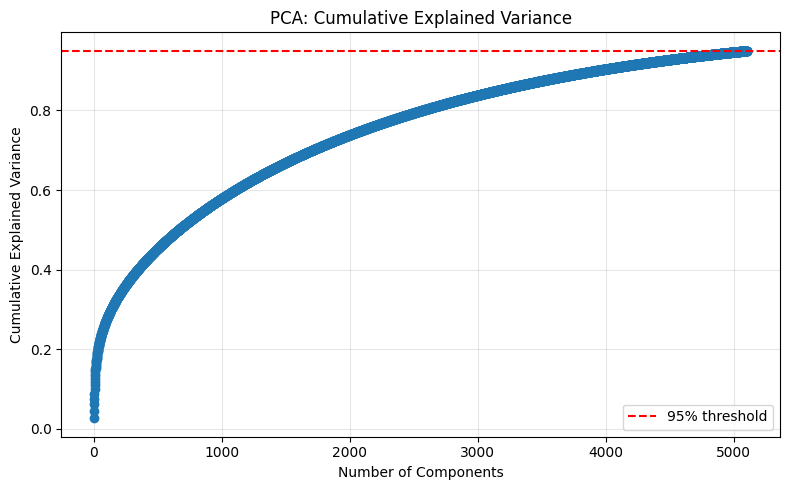

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os

# Paths
FEATURE_PATH = '/kaggle/working/module2/features'
OUTPUT_PATH = '/kaggle/working/module2/visualizations'

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Load features
X = np.load(os.path.join(FEATURE_PATH, 'X_features.npy'))
y = np.load(os.path.join(FEATURE_PATH, 'y_labels.npy'))

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Reduced features: {X_train_pca.shape[1]}")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.4f}")

# Plot explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Cumulative Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'pca_cumulative_variance.png'), dpi=300)
plt.show()


In [ ]:
# Required imports
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report

# List of classifiers
models = {
    "SVM (RBF)": SVC(kernel='rbf', C=10, gamma='scale', random_state=42),
    "SVM (Poly)": SVC(kernel='poly', degree=3, C=10, gamma='scale', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    "k-NN": KNeighborsClassifier(n_neighbors=5, weights='distance')
}

# Stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Train, predict, and evaluate
for name, model in models.items():
    print(f"\n{name}")
    print("-"*40)
    
    # Cross-validation
    scores = cross_val_score(model, X_train_pca, y_train, cv=skf, scoring='accuracy')
    print(f"CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")
    
    # Train on full training set
    model.fit(X_train_pca, y_train)
    
    # Test set evaluation
    y_pred = model.predict(X_test_pca)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))


**Module 3**

In [28]:
!pip install --upgrade numpy
!pip install --upgrade jax jaxlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 38.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 MB 12.7 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 73.6 MB/s eta 0:00:00:00:01
  Attempting uninstall: ml_dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
tensorflow 

In [23]:
# ============================================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================================

import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import glob
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ TensorFlow version:", tf.__version__)
print("✓ GPU available:", tf.config.list_physical_devices('GPU'))
print("✓ All libraries imported successfully!")

2025-12-03 14:17:38.939983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764771459.213250     748 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764771459.297240     748 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: module 'numpy' has no attribute 'dtypes'

In [22]:
# ============================================================================
# CELL 2: LOAD YOUR TRAINED INCEPTIONV3 MODEL
# ============================================================================



# Your class names (9 tomato diseases)
class_names = [
    'Bacterial_spot',
    'Early_blight',
    'Late_blight',
    'Leaf_Mold',
    'Septoria_leaf_spot',
    'Spider_mites',
    'Target_Spot',
    'Yellow_Leaf_Curl_Virus',
    'mosaic_virus'
]


print(f"✓ Number of classes: {len(class_names)}")

✓ Number of classes: 9


In [ ]:
# ============================================================================
# CELL 3: BUILD U-NET WITH PRETRAINED RESNET50 ENCODER
# ============================================================================

def build_unet_with_resnet50(input_shape=(256, 256, 3), freeze_encoder=True):
    """
    Build U-Net with pretrained ResNet50 encoder
    
    Encoder: ResNet50 pretrained on ImageNet (feature extraction)
    Decoder: Trained from scratch (learns segmentation)
    
    Parameters:
    - freeze_encoder: True = only train decoder (faster, use for <500 images)
                      False = fine-tune entire model (slower, use for >1000 images)
    """
    
    # Load pretrained ResNet50 without top (classification) layers
    base_model = keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',  # Use ImageNet pretrained weights
        input_shape=input_shape
    )
    
    # Freeze or unfreeze encoder
    base_model.trainable = not freeze_encoder
    
    if freeze_encoder:
        print("✓ Encoder FROZEN - Only decoder will train (faster, recommended)")
    else:
        print("✓ Encoder UNFROZEN - Fine-tuning entire network (slower)")
    
    # Get skip connection layers from ResNet50
    # These preserve spatial information at different resolutions
    layer_names = [
        'conv1_relu',           # 128x128, 64 channels
        'conv2_block3_out',     # 64x64, 256 channels
        'conv3_block4_out',     # 32x32, 512 channels
        'conv4_block6_out',     # 16x16, 1024 channels
    ]
    
    skip_connections = [base_model.get_layer(name).output for name in layer_names]
    
    # Bottleneck (deepest layer)
    bottleneck = base_model.output  # 8x8, 2048 channels
    
    # ========== DECODER (Upsampling with skip connections) ==========
    
    # Block 1: 8x8 → 16x16
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(bottleneck)
    x = layers.Conv2D(512, 3, activation='relu', padding='same', 
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.concatenate([x, skip_connections[3]])  # Skip connection
    x = layers.Conv2D(512, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    # Block 2: 16x16 → 32x32
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(256, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.concatenate([x, skip_connections[2]])
    x = layers.Conv2D(256, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    # Block 3: 32x32 → 64x64
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.concatenate([x, skip_connections[1]])
    x = layers.Conv2D(128, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    # Block 4: 64x64 → 128x128
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.concatenate([x, skip_connections[0]])
    x = layers.Conv2D(64, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    
    # Block 5: 128x128 → 256x256 (back to original size)
    x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same',
                      kernel_initializer='he_normal')(x)
    
    # Output layer: Binary segmentation mask
    outputs = layers.Conv2D(1, 1, activation='sigmoid', name='output')(x)
    
    # Create model
    model = keras.Model(inputs=base_model.input, outputs=outputs, 
                       name='U-Net-ResNet50')
    
    return model

# Build the model
unet_model = build_unet_with_resnet50(
    input_shape=(256, 256, 3),
    freeze_encoder=True  # Freeze encoder for faster training
)

print(f"\n✓ U-Net model built successfully!")
print(f"  Total parameters: {unet_model.count_params():,}")

# Count trainable vs non-trainable parameters
trainable_count = sum([tf.size(w).numpy() for w in unet_model.trainable_weights])
non_trainable_count = sum([tf.size(w).numpy() for w in unet_model.non_trainable_weights])

print(f"  Trainable parameters: {trainable_count:,}")
print(f"  Non-trainable parameters: {non_trainable_count:,}")
print(f"\n  Only {trainable_count/(trainable_count+non_trainable_count)*100:.1f}% of parameters need training!")


In [ ]:
# ============================================================================
# CELL 4: COMPILE MODEL
# ============================================================================

# Compile with appropriate loss and metrics
unet_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.MeanIoU(num_classes=2, name='iou'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall')
    ]
)

print("✓ Model compiled successfully!")
print("\nOptimizer: Adam (lr=1e-4)")
print("Loss: Binary Crossentropy")
print("Metrics: Accuracy, IoU, Precision, Recall")

In [ ]:
# ============================================================================
# CELL 7: PREPARE TRAINING DATASET
# ============================================================================

import glob
import cv2
import numpy as np

# ----------------------------
# Paths
# ----------------------------
TRAIN_PATH = '/kaggle/input/tomato/train/*/*.jpg'
VALID_PATH = '/kaggle/input/tomato/valid/*/*.jpg'
TEST_PATH  = '/kaggle/input/tomato/test/*/*.jpg'

# ----------------------------
# Get image paths
# ----------------------------
train_images = glob.glob(TRAIN_PATH)
valid_images = glob.glob(VALID_PATH)
test_images  = glob.glob(TEST_PATH)

print(f"Found {len(train_images)} training images")
print(f"Found {len(valid_images)} validation images")
print(f"Found {len(test_images)} test images")

# ----------------------------
# Use subset for faster training (optional)
# ----------------------------
num_training_images = 500
train_images = train_images[:num_training_images]

# ----------------------------
# Prepare training data
# ----------------------------
print("\nPreparing training data (images + pseudo masks)...")

X_train = []
y_train = []

for idx, img_path in enumerate(train_images):
    if (idx + 1) % 50 == 0:
        print(f"  Processed {idx+1}/{len(train_images)} images...")

    try:
        # Load image
        img = cv2.imread(img_path)
        if img is None:
            continue
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        
        # Generate pseudo mask
        mask = generate_pseudo_mask(img)
        
        # Normalize image to [0,1]
        img = img.astype(np.float32) / 255.0
        
        X_train.append(img)
        y_train.append(mask)
        
    except Exception as e:
        print(f"  Error processing {img_path}: {e}")
        continue

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)

print(f"\n✓ Training data prepared successfully!")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Memory usage: {(X_train.nbytes + y_train.nbytes) / (1024**2):.1f} MB")

# ----------------------------
# Dataset statistics
# ----------------------------
mean_disease_coverage = np.mean(y_train) * 100
num_diseased_images = np.sum(np.mean(y_train, axis=(1,2,3)) > 0.1)

print(f"\nDataset statistics:")
print(f"  Mean disease coverage: {mean_disease_coverage:.1f}%")
print(f"  Images with disease: {num_diseased_images}/{len(y_train)}")


In [ ]:
# ============================================================================
# CELL 8: SETUP CALLBACKS FOR TRAINING
# ============================================================================

# Create directory for saving models
os.makedirs('/kaggle/working/models', exist_ok=True)

# Define callbacks
callbacks = [
    # Save best model
    keras.callbacks.ModelCheckpoint(
        '/kaggle/working/models/unet_resnet50_best.keras',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ),
    
    # Early stopping to prevent overfitting
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Reduce learning rate when validation loss plateaus
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    
    # TensorBoard logging (optional)
    keras.callbacks.TensorBoard(
        log_dir='/kaggle/working/logs',
        histogram_freq=0,
        write_graph=False
    )
]

print("✓ Training callbacks configured:")
print("  • ModelCheckpoint - saves best model")
print("  • EarlyStopping - stops if no improvement for 3 epochs")
print("  • ReduceLROnPlateau - reduces learning rate if stuck")
print("  • TensorBoard - logs training metrics")

In [ ]:
# ============================================================================
# CELL 9: TRAIN U-NET (THIS WILL TAKE ~10 MINUTES)
# ============================================================================

print("="*70)
print("STARTING U-NET TRAINING WITH PRETRAINED RESNET50 ENCODER")
print("="*70)
print(f"\nTraining on {len(X_train)} images")
print(f"Batch size: 8")
print(f"Epochs: 5 (pretrained encoder needs fewer epochs!)")
print(f"Validation split: 20%")
print("\nEstimated time: ~10 minutes")
print("\nTraining starting...\n")

# Train the model
history = unet_model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=5,  # Only 5 epochs needed with pretrained encoder!
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*70)
print("✓ TRAINING COMPLETE!")
print("="*70)

# Final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_iou = history.history['iou'][-1]
final_val_iou = history.history['val_iou'][-1]

print(f"\nFinal Training Metrics:")
print(f"  Accuracy: {final_train_acc:.4f}")
print(f"  IoU: {final_train_iou:.4f}")

print(f"\nFinal Validation Metrics:")
print(f"  Accuracy: {final_val_acc:.4f}")
print(f"  IoU: {final_val_iou:.4f}")

print(f"\nModel saved to: /kaggle/working/models/unet_resnet50_best.h5")

# ============================================================================
# CELL 10: PLOT TRAINING HISTORY
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# IoU
axes[1, 0].plot(history.history['iou'], label='Train IoU', linewidth=2)
axes[1, 0].plot(history.history['val_iou'], label='Val IoU', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('IoU', fontsize=12)
axes[1, 0].set_title('Intersection over Union (IoU)', fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Learning Rate (if available)
if 'lr' in history.history:
    axes[1, 1].plot(history.history['lr'], linewidth=2, color='red')
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].axis('off')
    axes[1, 1].text(0.5, 0.5, 'Learning Rate\nNot Tracked', 
                   ha='center', va='center', fontsize=14)

plt.tight_layout()
plt.savefig('/kaggle/working/unet_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training history plotted and saved!")

In [38]:
# ============================================================================
# FIXED CODE - CORRECT PREPROCESSING FOR U-NET WITH RESNET50 ENCODER
# ============================================================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import ipywidgets as widgets
from IPython.display import display, clear_output

# ----------------------------
# STEP 1: Load Models
# ----------------------------
MODEL_PATH = '/kaggle/input/new-model/keras/default/1/improved_model.keras'
model = keras.models.load_model(MODEL_PATH)

UNET_PATH = '/kaggle/input/unet-resnet50-best/tensorflow2/default/1/unet_resnet50_best.keras'
unet_model = keras.models.load_model(UNET_PATH)

class_names = [
    'Bacterial_spot',
    'Early_blight',
    'Late_blight',
    'Leaf_Mold',
    'Septoria_leaf_spot',
    'Spider_mites',
    'Target_Spot',
    'Yellow_Leaf_Curl_Virus',
    'mosaic_virus'
]

print("✓ Models loaded successfully!")

# ----------------------------
# STEP 2: Grad-CAM & Segmentation (FIXED!)
# ----------------------------
def make_gradcam_heatmap(img_array, model, last_conv_layer_name='mixed10', pred_index=None):
    grad_model = keras.models.Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

def analyze_image(img_path):
    """
    FIXED VERSION - Correct preprocessing for U-Net with ResNet50 encoder
    """
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # ========== SEGMENTATION (FIXED PREPROCESSING!) ==========
    img_seg = cv2.resize(img, (256, 256))
    img_seg_input = np.expand_dims(img_seg, axis=0).astype(np.float32)
    
    # ✓ USE RESNET50 PREPROCESSING (since U-Net has ResNet50 encoder!)
    img_seg_input = keras.applications.resnet50.preprocess_input(img_seg_input)
    
    pred_mask = unet_model.predict(img_seg_input, verbose=0)[0]
    binary_mask = (pred_mask > 0.5).astype(np.uint8).squeeze()
    severity = np.sum(binary_mask) / binary_mask.size * 100
    
    if severity < 10:
        level, color = "Minimal", 'green'
    elif severity < 30:
        level, color = "Mild", 'yellow'
    elif severity < 60:
        level, color = "Moderate", 'orange'
    else:
        level, color = "Severe", 'red'
    
    # ========== GRAD-CAM (Already correct) ==========
    img_cls = cv2.resize(img, (299, 299))
    img_array = np.expand_dims(img_cls, axis=0)
    img_array = keras.applications.inception_v3.preprocess_input(img_array)
    
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    pred_conf = preds[0][pred_class]
    
    heatmap = make_gradcam_heatmap(img_array, model)
    gradcam_overlay = overlay_gradcam(img_cls, heatmap)
    
    # ========== VISUALIZATION ==========
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    
    # Row 1: Classification & Grad-CAM
    axes[0, 0].imshow(img_cls)
    axes[0, 0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(heatmap, cmap='jet')
    axes[0, 1].set_title('Grad-CAM Heatmap', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[0, 2].imshow(gradcam_overlay)
    axes[0, 2].set_title(f'Classification\n{class_names[pred_class]}\n({pred_conf:.1%})', 
                        fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')
    
    # Row 2: Segmentation
    axes[1, 0].imshow(img_seg)
    axes[1, 0].set_title('Segmentation Input', fontsize=12, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(binary_mask, cmap='gray')
    axes[1, 1].set_title('U-Net Mask\n(White = Diseased)', fontsize=12, fontweight='bold')
    axes[1, 1].axis('off')
    
    overlay = img_seg.copy()
    overlay[binary_mask == 1] = [255, 0, 0]
    blended = cv2.addWeighted(img_seg, 0.6, overlay, 0.4, 0)
    axes[1, 2].imshow(blended)
    axes[1, 2].set_title(f'Severity: {severity:.1f}%\n{level}', 
                        fontsize=12, fontweight='bold', color=color)
    axes[1, 2].axis('off')
    
    plt.suptitle('🌿 Complete Plant Disease Analysis 🌿', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # ========== PRINT SUMMARY ==========
    print("\n" + "="*70)
    print("📊 ANALYSIS RESULTS")
    print("="*70)
    print(f"🔬 Classification: {class_names[pred_class]} ({pred_conf:.1%})")
    print(f"📍 Severity: {severity:.1f}% ({level})")
    print("="*70)
    
    return {
        'image_path': img_path,
        'pred_class': class_names[pred_class],
        'confidence': pred_conf,
        'severity': severity,
        'severity_level': level
    }

# ----------------------------
# STEP 3: Dropdown Widgets
# ----------------------------
DATASET_PATH = '/kaggle/input/tomato/train'
subfolders = [f for f in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, f))]

folder_dropdown = widgets.Dropdown(
    options=subfolders,
    description='Folder:',
    layout=widgets.Layout(width='90%')
)
image_dropdown = widgets.Dropdown(
    options=[],
    description='Image:',
    layout=widgets.Layout(width='90%')
)
out = widgets.Output()

def update_images(change):
    folder_path = os.path.join(DATASET_PATH, folder_dropdown.value)
    images = [f for f in os.listdir(folder_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    image_dropdown.options = images
    if images:
        image_dropdown.value = images[0]

def analyze_selected_image(change):
    with out:
        clear_output(wait=True)
        img_path = os.path.join(DATASET_PATH, folder_dropdown.value, image_dropdown.value)
        print(f"Analyzing: {img_path}")
        analyze_image(img_path)

folder_dropdown.observe(update_images, names='value')
image_dropdown.observe(analyze_selected_image, names='value')

display(folder_dropdown)
display(image_dropdown)
display(out)

# Initialize images
update_images(None)

print("\n✓ Widget interface ready!")
print("  Select a folder and image from the dropdowns above")

✓ Models loaded successfully!


Dropdown(description='Folder:', layout=Layout(width='90%'), options=('Late_blight', 'Tomato_Yellow_Leaf_Curl_V…

Dropdown(description='Image:', layout=Layout(width='90%'), options=(), value=None)

Output()


✓ Widget interface ready!
  Select a folder and image from the dropdowns above
